In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

## Imports

In [2]:
from pathlib import Path
import shutil
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils.model import make_model, freeze_all_base_model, unfreeze_last_base_model
from utils.data import train_test_valid_split, filter_binary_labels, optimize_dataset, create_split, delete_folder

## Image files management -> train, test, valid splits

In [3]:
DATASET_SOURCE_PATH = Path(r'../data/dataset')
SPLITS_DESTINATION_PATH = Path(r'../data')
UNDERSAMPLE_RATIO = 0.8  # controls the under sampling for majority class. Use 'None' to disable
TEST_SIZE = 0.15
VALID_SIZE = 0.15

X_train, X_test, X_valid = train_test_valid_split(DATASET_SOURCE_PATH, test_size=TEST_SIZE, valid_size=VALID_SIZE, undersample_ratio=UNDERSAMPLE_RATIO)

splits = [('train', X_train), ('test', X_test), ('valid', X_valid)]

for split in splits:
    destination_path = Path(SPLITS_DESTINATION_PATH) / split[0]
    delete_folder(destination_path)
    create_split(split[1], destination_path)

--------------DELETE TRAIN SPLIT------------
--------------COPY TRAIN SPLIT------------


100%|███████████████████████████████████████████████████████████████████████████████| 781/781 [00:01<00:00, 597.30it/s]


--------------DELETE TEST SPLIT------------
--------------COPY TEST SPLIT------------


100%|███████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 521.30it/s]


--------------DELETE VALID SPLIT------------
--------------COPY VALID SPLIT------------


100%|███████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 691.51it/s]


## Dataset loading

In [4]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64
SEED = None

train_path = SPLITS_DESTINATION_PATH / 'train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_path, image_size=(IMG_HEIGHT, IMG_WIDTH),\
                                                               batch_size=BATCH_SIZE, shuffle=True, \
                                                               label_mode='categorical', seed=SEED)

valid_path = SPLITS_DESTINATION_PATH / 'valid'
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(valid_path, image_size=(IMG_HEIGHT, IMG_WIDTH),\
                                                               batch_size=BATCH_SIZE, shuffle=True, \
                                                               label_mode='categorical', seed=SEED)

class_names = train_ds.class_names
assert class_names == valid_ds.class_names
AUTOTUNE = tf.data.AUTOTUNE

if len(class_names) == 2:  # take the one-hot-encoded matrix of labels and convert to a vector if binary classification
    train_ds = train_ds.map(filter_binary_labels, num_parallel_calls=AUTOTUNE)
    valid_ds = valid_ds.map(filter_binary_labels, num_parallel_calls=AUTOTUNE)

train_ds = optimize_dataset(train_ds)
valid_ds = optimize_dataset(valid_ds)

Found 780 files belonging to 2 classes.
Found 168 files belonging to 2 classes.


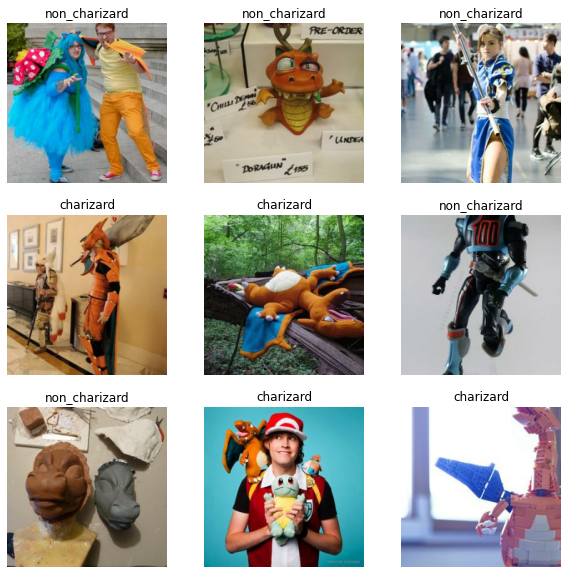

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_idx = labels.numpy()[i][0] if len(class_names) == 2 else np.argmax(labels.numpy()[i], axis=0)
        plt.title(class_names[label_idx])
        plt.axis("off")

## Model

In [5]:
N_HIDDEN = 512
BASE_LR = 0.001

model = make_model(n_classes=len(class_names), n_hidden=N_HIDDEN, img_height=IMG_HEIGHT, img_width=IMG_WIDTH)
freeze_all_base_model(model)

loss = tf.keras.losses.CategoricalCrossentropy() if len(class_names) > 2 else tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LR),
              loss=loss, metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                             

#### Classifier initial training

In [8]:
# TODO - delete last trained model

In [6]:
LOG_PATH = Path(r'../models/vgg16/logs')
CHECKPOINTS_PATH = Path(r'../models/vgg16/checkpoints')
BASE_EPOCHS = 30

tb = TensorBoard(log_dir=LOG_PATH)
checkpoint = ModelCheckpoint(CHECKPOINTS_PATH / 'train_{epoch}.tf', verbose=1, save_weights_only=True,
                             save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1)

history = model.fit(train_ds, epochs=BASE_EPOCHS, validation_data=valid_ds, callbacks=[tb, checkpoint, reduce_lr,
                                                                                       early_stopping])

Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.6641
Epoch 1: val_loss improved from inf to 1.26364, saving model to ..\models\vgg16\checkpoints\train_1.tf
13/13 [==============================] - 29s 1s/step - loss: 0.6904 - accuracy: 0.6641 - val_loss: 1.2636 - val_accuracy: 0.7381 - lr: 0.0010
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.5052 - accuracy: 0.8013
Epoch 2: val_loss improved from 1.26364 to 0.78179, saving model to ..\models\vgg16\checkpoints\train_2.tf
13/13 [==============================] - 10s 790ms/step - loss: 0.5052 - accuracy: 0.8013 - val_loss: 0.7818 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.3544 - accuracy: 0.8551
Epoch 3: val_loss did not improve from 0.78179
13/13 [==============================] - 8s 637ms/step - loss: 0.3544 - accuracy: 0.8551 - val_loss: 1.0704 - val_accuracy: 0.7440 - lr: 0.0010
Epoch 4/30
13/13 [============

Epoch 27/30
13/13 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9756
Epoch 27: val_loss did not improve from 0.70627
13/13 [==============================] - 8s 634ms/step - loss: 0.0751 - accuracy: 0.9756 - val_loss: 0.7226 - val_accuracy: 0.8095 - lr: 1.0000e-06
Epoch 28/30
13/13 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.9641
Epoch 28: val_loss did not improve from 0.70627

Epoch 28: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
13/13 [==============================] - 8s 634ms/step - loss: 0.0890 - accuracy: 0.9641 - val_loss: 0.7231 - val_accuracy: 0.8036 - lr: 1.0000e-06
Epoch 29/30
13/13 [==============================] - ETA: 0s - loss: 0.0569 - accuracy: 0.9846
Epoch 29: val_loss did not improve from 0.70627
13/13 [==============================] - 8s 634ms/step - loss: 0.0569 - accuracy: 0.9846 - val_loss: 0.7220 - val_accuracy: 0.8036 - lr: 1.0000e-07
Epoch 30/30
13/13 [=============================

#### Fine tuning

In [7]:
FINE_TUNE_AT_LAYER = 15
FINE_TUNING_EPOCHS = 30
FINE_TUNING_LR = 0.001
FINAL_MODEL_NAME = 'trained_weights'
FINAL_MODEL_SAVE_PATH = CHECKPOINTS_PATH / FINAL_MODEL_NAME

unfreeze_last_base_model(model, which_freeze=FINE_TUNE_AT_LAYER)

total_epochs = BASE_EPOCHS + FINE_TUNING_EPOCHS
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNING_LR),
              loss=loss, metrics=['accuracy'])
history = model.fit(train_ds, epochs=total_epochs, validation_data=valid_ds, callbacks=[tb, checkpoint, reduce_lr, early_stopping], \
                    initial_epoch=history.epoch[-1])

model.save(FINAL_MODEL_SAVE_PATH, save_format='h5')

Epoch 30/60
13/13 [==============================] - ETA: 0s - loss: 0.9074 - accuracy: 0.6654
Epoch 30: val_loss did not improve from 0.70627
13/13 [==============================] - 11s 720ms/step - loss: 0.9074 - accuracy: 0.6654 - val_loss: 1.5972 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 31/60
13/13 [==============================] - ETA: 0s - loss: 0.6478 - accuracy: 0.7038
Epoch 31: val_loss did not improve from 0.70627
13/13 [==============================] - 9s 688ms/step - loss: 0.6478 - accuracy: 0.7038 - val_loss: 4.2537 - val_accuracy: 0.5655 - lr: 0.0010
Epoch 32/60
13/13 [==============================] - ETA: 0s - loss: 0.5937 - accuracy: 0.7218
Epoch 32: val_loss did not improve from 0.70627
13/13 [==============================] - 9s 688ms/step - loss: 0.5937 - accuracy: 0.7218 - val_loss: 2.3084 - val_accuracy: 0.5774 - lr: 0.0010
Epoch 33/60
13/13 [==============================] - ETA: 0s - loss: 0.4921 - accuracy: 0.7769
Epoch 33: val_loss did not improve from 0.7

#### Model evaluation

In [10]:
# TODO - load model if not trained

In [13]:
test_path = Path(r'../data/test')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_path, image_size=(IMG_HEIGHT, IMG_WIDTH), \
                                                              batch_size=BATCH_SIZE, shuffle=False, \
                                                              label_mode='categorical')
assert class_names == test_ds.class_names

if len(class_names) == 2:  # take the one-hot-encoded matrix of labels and convert to a vector if binary classification
    test_ds = test_ds.map(filter_binary_labels, num_parallel_calls=AUTOTUNE)
test_ds = optimize_dataset(test_ds)

metrics = model.evaluate(test_ds)
print('Loss: {} --------- Accuracy: {}%'.format(metrics[0], np.round(metrics[1]*100, 2)))

y_pred = model.predict(test_ds)
y_true = tf.concat([y for x, y in test_ds], axis=0)
if len(class_names) == 2: # uses a threshold for the predictions if binary classification problem
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
    y_true = y_true.numpy()
else: # uses argmax if not binary classification
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_true.numpy(), axis=1)

print(classification_report(y_true, y_pred, target_names=class_names, digits=2))

pred_labels = [('PRED_' + class_name) for class_name in class_names]
real_labels = [('REAL_' + class_name) for class_name in class_names]
pd.DataFrame(confusion_matrix(y_true, y_pred), columns=pred_labels, index=real_labels)

Found 177 files belonging to 2 classes.
3/3 [==============================] - 14s 7s/step - loss: 0.3680 - accuracy: 0.8701
Loss: 0.36798617243766785 --------- Accuracy: 87.01%
              precision    recall  f1-score   support

           0       0.95      0.81      0.88       102
           1       0.79      0.95      0.86        75

    accuracy                           0.87       177
   macro avg       0.87      0.88      0.87       177
weighted avg       0.88      0.87      0.87       177



,PRED_0,PRED_1
REAL_0,83,19
REAL_1,4,71
